## Importing the relevant packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [3]:
raw_csv_data = pd.read_csv("Index_modified.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
'''df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')'''

"df_comp=df_comp.asfreq('b')\ndf_comp=df_comp.fillna(method='ffill')"

In [4]:
df_comp['market_value']=df_comp.ftse

In [5]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [7]:
import warnings
warnings.filterwarnings("ignore")

## The LLR Test

In [8]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit(start_ar_lags = 11).llf
    L2 = mod_2.fit(start_ar_lags = 11).llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns

In [9]:
df['returns'] = df.market_value.pct_change(1)*100

## Creating Squared Returns

In [10]:
df['sq_returns'] = df.returns.mul(df.returns)

## Returns vs Squared Returns

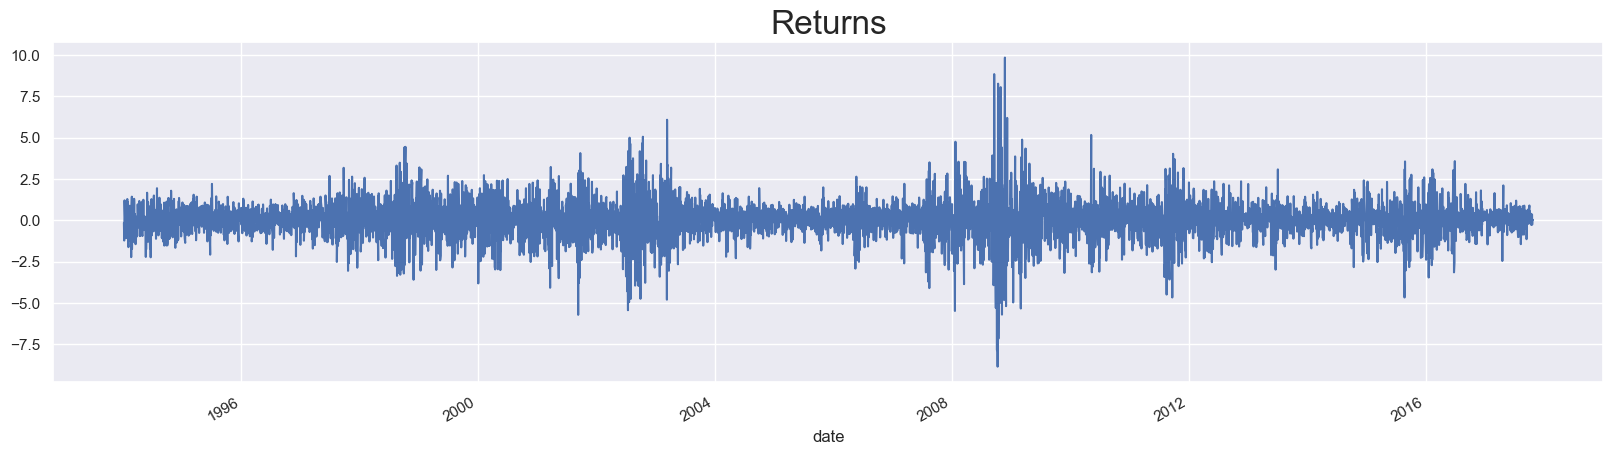

In [11]:
df.returns.plot(figsize=(20,5))
plt.title("Returns", size = 24)
plt.show()

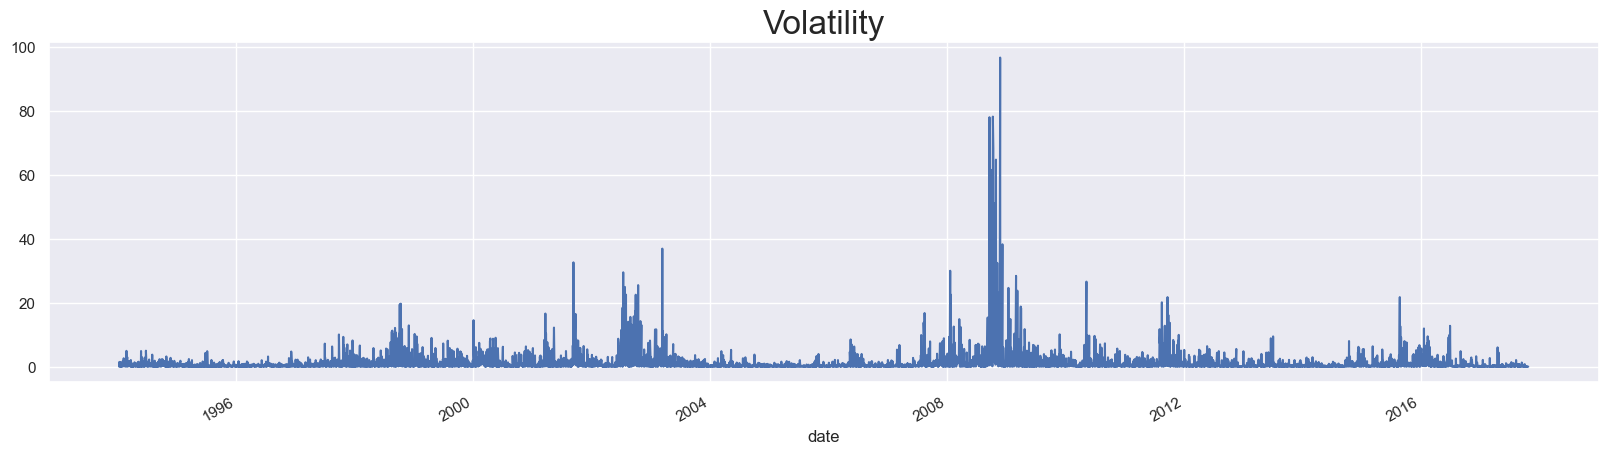

In [12]:
df.sq_returns.plot(figsize=(20,5))
plt.title("Volatility", size = 24)
plt.show()

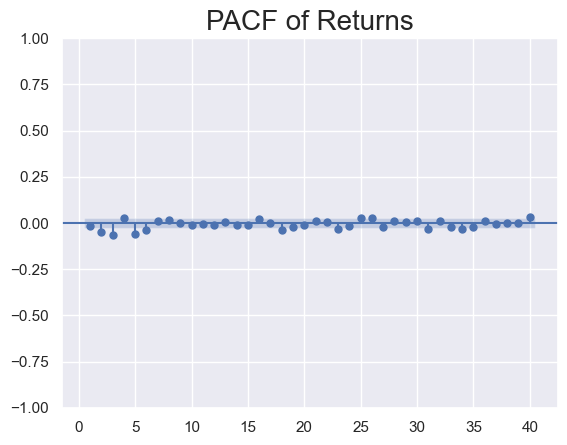

In [13]:
sgt.plot_pacf(df.returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Returns", size = 20)
plt.show()

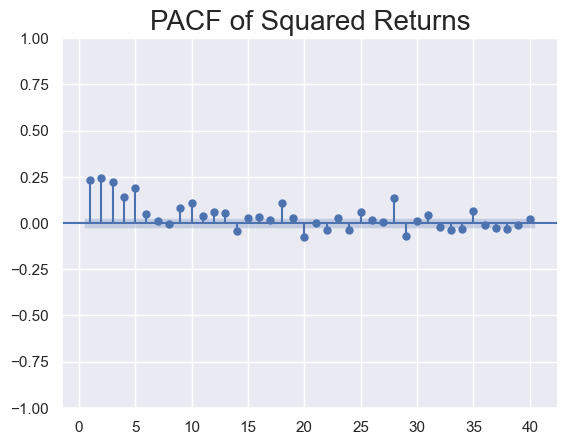

In [14]:
sgt.plot_pacf(df.sq_returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Squared Returns", size = 20)
plt.show()

## The arch_model() Method

In [15]:
from arch import arch_model

In [16]:
model_arch_1 = arch_model(df.returns[1:])
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     35,   Neg. LLF: 8358.943798924995
Iteration:     10,   Func. Count:     64,   Neg. LLF: 8352.43143814438
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8352.431436831816
            Iterations: 12
            Function evaluations: 73
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8352.43
Distribution:                  Normal   AIC:                           16712.9
Method:            Maximum Likelihood   BIC:                           16739.8
                                        No. Observations:                 6200
Date:                Sat, Oct 14 2023   Df Residuals:                     6199
Time:                        19:13:19   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0429  1.044e-02      4.112  3.925e-05 [2.247e-02,6.341e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0129  3.372e-03      3.819  1.342e-04 [6.268e-03,1.949e-02]
alpha[1]       0.0893  1.143e-02      7.814  5.522e-15   [6.692e-02,  0.112]
beta[1]        0.9002  1.283e-02     70.157      0.000     [  0.875,  0.925]
============================================================================

Covariance estimator: robust
"""

## The Simple ARCH(1) 

In [17]:
model_arch_1 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 1)
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     30,   Neg. LLF: 9159.78065365702
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9159.78065365702
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9159.78
Distribution:                  Normal   AIC:                           18325.6
Method:            Maximum Likelihood   BIC:                           18345.8
                                        No. Observations:                 6200
Date:                Sat, Oct 14 2023   Df Residuals:                     6199
Time:                        19:13:19   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0348  1.381e-02      2.518  1.181e-02 [7.701e-03,6.182e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.8268  3.524e-02     23.459 1.061e-121 [  0.758,  0.896]
alpha[1]       0.3814  4.609e-02      8.276  1.272e-16 [  0.291,  0.472]
========================================================================

Covariance estimator: robust
"""

In [18]:
model_arch_1 = arch_model(df.returns[1:], mean = "AR", lags = [2, 3, 6], vol = "ARCH", p = 1, dist = "ged")
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     52,   Neg. LLF: 29466.17292212425
Iteration:     10,   Func. Count:    100,   Neg. LLF: 8767.47013620516
Iteration:     15,   Func. Count:    144,   Neg. LLF: 8739.178057927758
Iteration:     20,   Func. Count:    187,   Neg. LLF: 8739.174145613004
Iteration:     25,   Func. Count:    230,   Neg. LLF: 8739.173982219992
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8739.173964481248
            Iterations: 25
            Function evaluations: 233
            Gradient evaluations: 25


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - ARCH Model Results                                  
==========================================================================================
Dep. Variable:                            returns   R-squared:                       0.005
Mean Model:                                    AR   Adj. R-squared:                  0.004
Vol Model:                                   ARCH   Log-Likelihood:               -8739.17
Distribution:      Generalized Error Distribution   AIC:                           17492.3
Method:                        Maximum Likelihood   BIC:                           17539.5
                                                    No. Observations:                 6194
Date:                            Sat, Oct 14 2023   Df Residuals:                     6190
Time:                                    19:13:19   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0422  1.241e-03     34.026 9.145e-254   [3.980e-02,4.467e-02]
returns[2]    -0.0353  1.887e-03    -18.690  5.920e-78 [-3.897e-02,-3.158e-02]
returns[3]    -0.0213  4.749e-03     -4.484  7.324e-06 [-3.061e-02,-1.199e-02]
returns[6]    -0.0165  2.938e-03     -5.615  1.970e-08 [-2.225e-02,-1.074e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.8211  3.018e-02     27.203 5.918e-163 [  0.762,  0.880]
alpha[1]       0.3639  3.566e-02     10.204  1.908e-24 [  0.294,  0.434]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0608  2.796e-02     37.944      0.000 [  1.006,  1.116]
========================================================================

Covariance estimator: robust
"""

## Higher-Lag ARCH Models

In [19]:
model_arch_2 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 2)
results_arch_2 = model_arch_2.fit(update_freq = 5)
results_arch_2.summary()

Iteration:      5,   Func. Count:     39,   Neg. LLF: 8911.484485910141
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8911.483599931935
            Iterations: 7
            Function evaluations: 48
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8911.48
Distribution:                  Normal   AIC:                           17831.0
Method:            Maximum Likelihood   BIC:                           17857.9
                                        No. Observations:                 6200
Date:                Sat, Oct 14 2023   Df Residuals:                     6199
Time:                        19:13:19   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0425  1.200e-02      3.538  4.039e-04 [1.894e-02,6.599e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6312  2.968e-02     21.267 2.317e-100 [  0.573,  0.689]
alpha[1]       0.2366  3.246e-02      7.290  3.103e-13 [  0.173,  0.300]
alpha[2]       0.2689  3.214e-02      8.366  5.948e-17 [  0.206,  0.332]
========================================================================

Covariance estimator: robust
"""

In [20]:
model_arch_3 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 3)
results_arch_3 = model_arch_3.fit(update_freq = 5)
results_arch_3.summary()

Iteration:      5,   Func. Count:     42,   Neg. LLF: 8891.881285899717
Iteration:     10,   Func. Count:     75,   Neg. LLF: 8695.903641305853
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8695.903641305962
            Iterations: 10
            Function evaluations: 75
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8695.90
Distribution:                  Normal   AIC:                           17401.8
Method:            Maximum Likelihood   BIC:                           17435.5
                                        No. Observations:                 6200
Date:                Sat, Oct 14 2023   Df Residuals:                     6199
Time:                        19:13:19   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0477  1.138e-02      4.190  2.796e-05 [2.537e-02,6.997e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.4585  2.323e-02     19.742  9.478e-87 [  0.413,  0.504]
alpha[1]       0.1666  2.447e-02      6.807  9.943e-12 [  0.119,  0.215]
alpha[2]       0.2075  2.274e-02      9.127  7.015e-20 [  0.163,  0.252]
alpha[3]       0.2784  2.976e-02      9.356  8.251e-21 [  0.220,  0.337]
========================================================================

Covariance estimator: robust
"""

In [21]:
model_arch_13 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 13)
results_arch_13 = model_arch_13.fit(update_freq = 5)
results_arch_13.summary()

Iteration:      5,   Func. Count:     90,   Neg. LLF: 11270.494323543933
Iteration:     10,   Func. Count:    180,   Neg. LLF: 9727.910297616905
Iteration:     15,   Func. Count:    269,   Neg. LLF: 9169.862987904206
Iteration:     20,   Func. Count:    359,   Neg. LLF: 8413.68870764389
Iteration:     25,   Func. Count:    447,   Neg. LLF: 8368.153464894684
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8368.144765923487
            Iterations: 28
            Function evaluations: 495
            Gradient evaluations: 28


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8368.14
Distribution:                  Normal   AIC:                           16766.3
Method:            Maximum Likelihood   BIC:                           16867.3
                                        No. Observations:                 6200
Date:                Sat, Oct 14 2023   Df Residuals:                     6199
Time:                        19:13:20   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0468  1.059e-02      4.415  1.008e-05 [2.600e-02,6.751e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1890  2.009e-02      9.408  5.066e-21     [  0.150,  0.228]
alpha[1]       0.0724  1.728e-02      4.191  2.783e-05   [3.854e-02,  0.106]
alpha[2]       0.1096  1.815e-02      6.039  1.554e-09   [7.401e-02,  0.145]
alpha[3]       0.1327  2.309e-02      5.746  9.156e-09   [8.740e-02,  0.178]
alpha[4]       0.0841  1.813e-02      4.638  3.523e-06   [4.856e-02,  0.120]
alpha[5]       0.0696  1.634e-02      4.259  2.053e-05   [3.757e-02,  0.102]
alpha[6]       0.0812  1.678e-02      4.837  1.317e-06   [4.827e-02,  0.114]
alpha[7]       0.0436  1.711e-02      2.550  1.077e-02 [1.010e-02,7.717e-02]
alpha[8]       0.0601  1.651e-02      3.644  2.683e-04 [2.780e-02,9.250e-02]
alpha[9]       0.0302  1.468e-02      2.055  3.987e-02 [1.396e-03,5.895e-02]
alpha[10]      0.0287  1.450e-02      1.979  4.782e-02 [2.752e-04,5.712e-02]
alpha[11]      0.0672  1.613e-02      4.163  3.134e-05 [3.555e-02,9.879e-02]
alpha[12]      0.0429  1.609e-02      2.667  7.662e-03 [1.137e-02,7.446e-02]
alpha[13]      0.0302  1.271e-02      2.376  1.750e-02 [5.288e-03,5.510e-02]
============================================================================

Covariance estimator: robust
"""